# 内容提要
### 1.装饰器
### 2.对象周期
### 3.内存管理机制
____
_____

## 1.装饰器

In [1]:
def check_func(func):
    def inner_func():
        print("Check something first...")
        func()
    return inner_func

@check_func
def eat_food():
    print("Eat food")
    
eat_food()

In [2]:
# 上述的这个相当于

def check_func(func):
    def inner_func():
        print("Check something first...")
        func()
    return inner_func


def eat_food():
    print("Eat food")
    
f = check_func(eat_food)
f()


Check something first...
Eat food


In [3]:
# 也可以用对象实现

class Checker(object):
    def __init__(self, func):
        self.f = func
        
    def __call__(self, *args, **kwargs):
        print("Check something first...")
        self.f()

@Checker
def eat_foods():
    print("Eat foods")
    
eat_foods()       

Check something first...
Eat foods


## 2.对象周期

### 1）__ new __ 方法： 创建对象时，用于给对象分配内存的方法。通过拦截这个方法，可以修改对象的创建过程，比如单例模式

In [4]:
class Person(object):
    pass
        
class FakePerson(object):
    def __new__(cls, *args, **kwargs):
        print("Aha...")

real_person = Person()
fake_person = FakePerson()

print(real_person) 
print(fake_person)   #对象没被创建

Aha...
None


### 2) __init__方法：对象创建好之后，对其进行初始化
### 3) __del__方法：对象销毁时的操作

【注】引用全局变量时需要加global
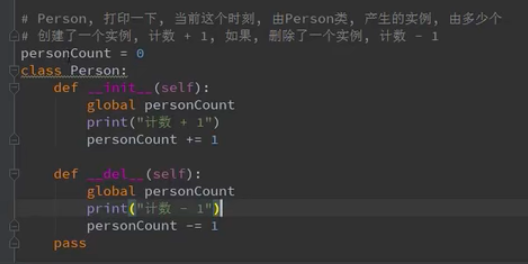

上述这种可以改成类属性，注意不是 self.属性 而是 类名.属性
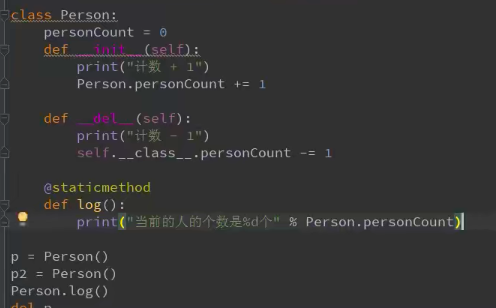
上述静态方法也可以换成类方法。注意用cls

## 3.内存管理机制

### 1）存储方面

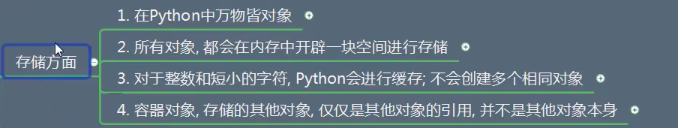

1.不存在基本的数据类型，它们全是对象  
2.变量存的都是对象的引用，id()为十进制地址，hex()对应为16进制地址  
3.具体见下：它们都用的同一个


In [5]:
p = 1
j = 1
print(id(p),"  ",id(j))  # 常用的会是这样，都是预先缓存的

a = 700
k = 700
print(id(a),"  ",id(k))  # 不常用的就不一样了

4538636480    4538636480
4578135184    4578134736


### 2）引用计数

In [6]:
import sys
class Person(object):
    pass

p1 = Person()
print(sys.getrefcount(p1))  #2 比当前引用多一个

p2 = p1
print(sys.getrefcount(p1))  #3

del p2
print(sys.getrefcount(p1))  #2

# print(sys.getrefcount(p2))  #都删了当然报错

2
3
2


In [7]:
import sys
class Person(object):
    pass

def log(ob):
    print(sys.getrefcount(ob))
    
p1 = Person()              
log(p1)                     #4 如果传递对象，那么函数内部会有两个属性引用这个对象，因此计数会+2

print(sys.getrefcount(p1))  #2 函数执行完，又变成2了

li = [p1]
print(sys.getrefcount(p1))  #3 如果放容器里，计数自动加1，因为容器里保存的都是引用，并非对象本身

                            # 一个对象若包含其它对象的引用，那么该对象也是一个容器

4
2
3


### 【循环引用】具体见下方例子


In [8]:
# objgraph.count(类名) 表示某个类当前内存中存在的对象个数

import objgraph

class A(object):
    pass

class B(object):
    pass

a = A()
b = B()
c = A()

print(objgraph.count("A"))   # 2         
print(objgraph.count("B"))   # 1

del a
del b
del c

print(objgraph.count("A"))   # 0
print(objgraph.count("B"))   # 0

2
1
0
0


In [9]:
# 循环引用的例子

# 就是一个对象直接或者间接引用自己本身，引用链形成一个环

# 下面这个例子是ok的，但如果打开第18行，那么就形成了循环引用
import objgraph

class A(object):
    pass

class B(object):
    pass

a = A()
b = B()

a.m = b
#b.n = a

print(objgraph.count("A"))   # 1         
print(objgraph.count("B"))   # 1

del a
del b

print(objgraph.count("A"))   # 0  
print(objgraph.count("B"))   # 0

1
1
0
0


In [10]:
# 下面这个例子就是循环引用(间接引用自己)

import objgraph

class A(object):
    pass

class B(object):
    pass

a = A()
b = B()

a.m = b
b.n = a

print(objgraph.count("A"))   # 1         
print(objgraph.count("B"))   # 1

del a
del b

print(objgraph.count("A"))   # 1  
print(objgraph.count("B"))   # 1

1
1
1
1


In [11]:
# 这个例子也是循环引用(直接引用自己)

import objgraph

class C(object):
    pass

a = C()
a.m = a

print(objgraph.count("C"))   # 1         
del a
print(objgraph.count("C"))   # 1 


1
1


### 3）垃圾回收机制

主要作用：引用计数器机制没有释放掉的对象中找到循环引用，干掉相关对象
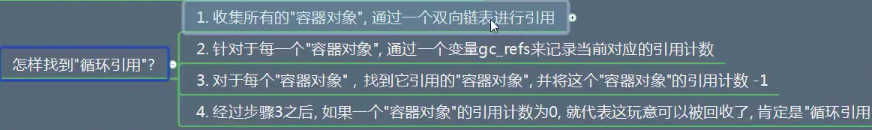  
由于循环引用，使得对象又引用了一遍自己，因此算得引用计数为0

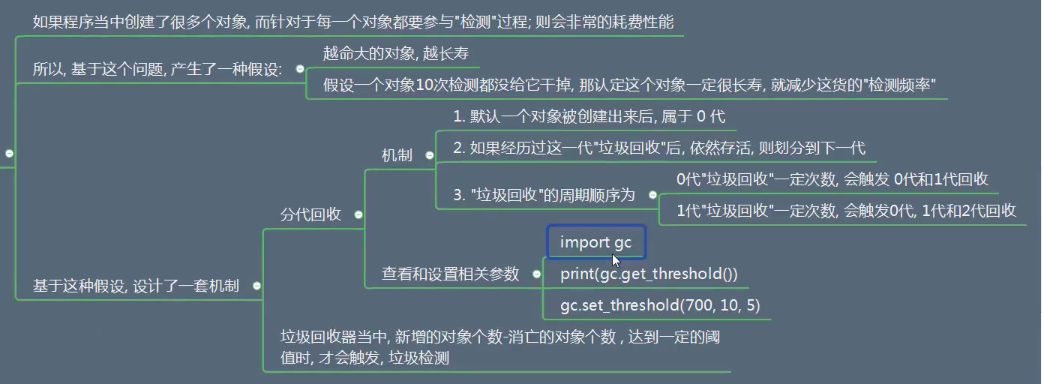

假设“一定次数”是10次，上图的意思就是，假设0代的检测了10次，那么接下来1代的会被检测1次（0代的也同样跟着检测1次）。
当0代的检测100次时，1代的会被检测10次，此时2代的也会跟着检测一次。

In [12]:
# 垃圾回收机制之自动回收

import gc
print(gc.get_threshold()) # (700, 10, 10) 
# 第1个参数 700 ： 新增对象个数 - 消亡对象个数 > 700时会触发一次垃圾检测，也就是说，垃圾回收并不能实时的触发！！！#
# 第2个参数 10  ： 0代的检测每满10次时，1代的检测一次
# 第3个参数 10  ： 1代的检测每满10次时，2代的检测一次

#gc.set_threshold(200, 5, 5) 用来设置参数

print(gc.isenabled())  # 垃圾回收是否被启用

gc.disable()   # 关闭垃圾回收
gc.enable()    # 开启垃圾回收

(700, 10, 10)
True


In [13]:
# 垃圾回收机制之手动回收

import objgraph
import gc

class D(object):
    pass

a = D()
a.m = a

print(objgraph.count("D"))   # 1        
del a
gc.collect()                 # 手动开启垃圾回收，即使是关闭状态，也照样回收
                             # 参数为0 ： 回收0代垃圾
                             # 参数为1 ： 回收0代和1代垃圾
print(objgraph.count("D"))   # 参数为2或没有参数 ： 回收所有垃圾 

1
0
